Boosting consists of iteratively training weak learners (classifiers that are not much better than randomly guessing). The next iteration is typically trained on the mistakes of previous iterations of classifiers. Unlike the other ensemble methods, this is targeted at reducing bias (bagging targets variance reduction).

Boosting can be done in the following steps:
1) From the training dataset $D$, draw a random subset of examples, $d_1$ without replacement to train a weak learner $C_1$.
2) Draw a second training subset, $d_2$ randomly without replacement, and add half the examples that $C_1$ misclassified to $d_2$. Train a second weak classifier $C_2$ on this.
3) Find the subset $d_3 \sub D$ that $C_1$ and $C_2$ diagree on, to train a third weak learner, $C_3$.
4) Use majority voting to combine $C_1, C_2$ and $C_3$.

The Adaptive Boosting algorithm, AdaBoost, uses the complete training data to train the weak learners instead of breaking into subsets. Instead of using partial data training, AdaBoost reweights the training examples that were misclassified in previous iterations to be larger, and those that were correct to be smaller. After this is done iteratively for a few rounds, majority voting is used once more.

AdaBoost, in practice, can end up with high variance.

AdaBoost Algortihm:
1) Choose a weight vector $w_i$ to sum componentwise to 1, with all weights uniform.
2) Let there be $m$ boosting rounds. For the $j^{th}$ round,

    a) Train a weighted weak learner $C_j$ with $X_{train}, y_{train}$ with the weights $w$

    b) Predict i.e. $\hat{y} = C_j(X)$

    c) Compute the weighted error $\varepsilon \equiv w \cdot (\hat{y} \neq y)$ and compute $\alpha_j \equiv \frac{1}{2} \log\frac{1-\varepsilon}{\varepsilon}$

    d) Update the weights $w_i = w_i \times \exp\left(- \alpha_j \times \hat{y}_i \times y_i \right)$

    e) Normalize w by $w \rightarrow w / \sum_i w_i$

3) Compute the final prediction $\hat{y} = \sum_{j = 1}^m (\alpha_j C_j(X) > 0)$

In [11]:
# Example on weights update
import numpy as np

y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
pred = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct_preds = (y == pred)

weights = np.full(10, 1/10)
print(f"Initial weights: {weights}")

incorrect = ~correct_preds
epsilon = np.mean(incorrect)
print(f"Error rate: {epsilon}")

alpha_j = 0.5 * np.log((1 - epsilon) / epsilon)

print(f"alpha_j: {alpha_j}")

weights = weights * np.exp(-alpha_j * pred * y)
print(f"Updated weights: {weights}")
weights /= np.sum(weights)
print(f"Normalized weights: {weights}")

Initial weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Error rate: 0.3
alpha_j: 0.42364893019360184
Updated weights: [0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]
Normalized weights: [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

import os

original_dir = os.getcwd()
os.chdir('..')

from decision_plotting import DecisionRegionPlotter
os.chdir(original_dir)

drp = DecisionRegionPlotter()

In [14]:
rnd_state = 1

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
le = LabelEncoder()
y = le.fit_transform(y)
# This is the true test set. The split inside the sequential backward selection is for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=rnd_state)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=rnd_state)

tree = tree.fit(X_train, y_train)

tree_acc_train = accuracy_score(y_train, tree.predict(X_train))
tree_acc_test = accuracy_score(y_test, tree.predict(X_test))

print(f"Training accuracy on the single tree: {tree_acc_train:.3f}")
print(f"Test accuracy on the single tree: {tree_acc_test:.3f}")

Training accuracy on the single tree: 0.597
Test accuracy on the single tree: 0.611


In [17]:
# The tree is clearly a very weak learner - barely better than random guessing
# Let's train the boosted classifier

ada.fit(X_train, y_train)

ada_acc_train = accuracy_score(y_train, ada.predict(X_train))
ada_acc_test = accuracy_score(y_test, ada.predict(X_test))

print(f"Training accuracy on the boosted classifier: {ada_acc_train:.3f}")
print(f"Test accuracy on the boosted classifier: {ada_acc_test:.3f}")

Training accuracy on the boosted classifier: 0.919
Test accuracy on the boosted classifier: 0.907


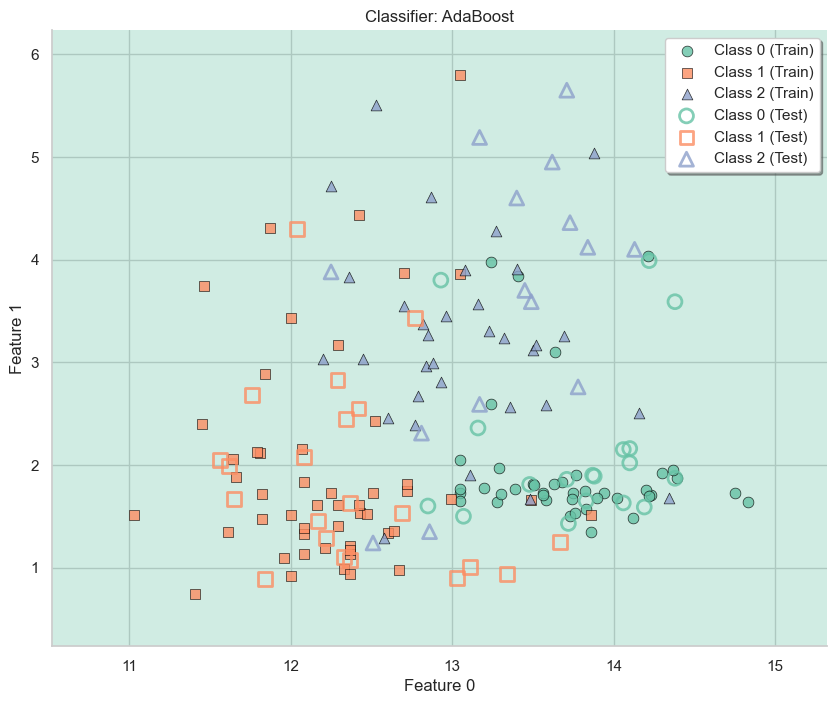

Processed 73264 predictions in 8 batches


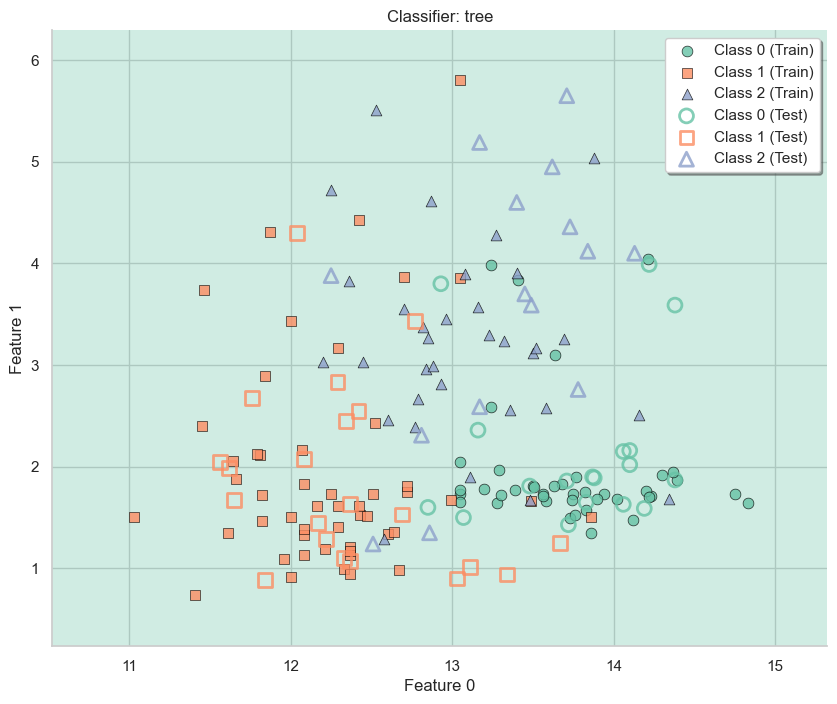

In [ ]:
drp.plot_decision_regions(classifier=ada, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
plt.title(f"Classifier: AdaBoost")
plt.show()

drp.plot_decision_regions(classifier=tree, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
plt.title(f"Classifier: tree")
plt.show()

Note that the training times are always significantly greater for the ensemble methods, given how many different classifiers they have to train. It can be impractical for applications that require a low training cost, whether in terms of time or resources.